# Linear Regression from Scratch

The purpose of this project is to gain a more complete understanding of linear regression by examining into the details of how and why the model works. The most common way of recreating linear regression from scratch is to simply rewrite the formula in python, but I find that looking at the formula alone is not always enough to understand *how* it works. Instead, we will break the formula down into pieces that are easier to understand. We'll calculate one piece at a time, put the whole model together, and then check our work using seaborn and statsmodels. Credit to [Brandon Foltz's youtube channel](https://www.youtube.com/@BrandonFoltz) for inspiring this project.

The goal for our model will be to built a simple linear regression  from scratch that models the relationship between a home’s square footage and its sales price. Our data consists of 1,098 homes sold in Tillamook County, OR from June 2021 to October 2022.

In [166]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt  
from sklearn.linear_model import LinearRegression 
import seaborn as sns
from statsmodels.formula.api import ols
pd.options.display.float_format = '{:20,.2f}'.format

First we’ll import the csv file and use the info, describe, and head functions from the pandas library to get an overall picture of what our data looks like. Since our goal is to understand linear regression, we don’t have to worry about splitting the data up into training and testing portions.

In [167]:
df = pd.read_csv('tillamook_home_sales.csv')
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098 entries, 0 to 1097
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   address         1092 non-null   object 
 1   acres           1072 non-null   float64
 2   year_built      1096 non-null   float64
 3   square_feet     1098 non-null   object 
 4   bedrooms        1098 non-null   int64  
 5   bathrooms       1098 non-null   int64  
 6   half_bathrooms  1098 non-null   int64  
 7   sale_price      1098 non-null   object 
 8   sale_date       1098 non-null   object 
dtypes: float64(2), int64(3), object(4)
memory usage: 77.3+ KB


,address,acres,year_built,square_feet,bedrooms,bathrooms,half_bathrooms,sale_price,sale_date
0,14905 HWY 101 N COUNTY OR,0.06,"1,992.00",896,2,1,0,"$290,000",6/1/2021
1,1 SHORT BEACH WAY COUNTY OR,10.36,"2,002.00","2,428",2,2,0,"$1,600,000",6/1/2021
2,131 CLASSIC ST MANZANITA OR,NaN,"1,999.00","1,373",3,2,1,"$430,000",6/1/2021
3,2513 5TH ST TILLAMOOK OR,0.18,"1,910.00","2,396",4,2,0,"$365,000",6/1/2021
4,34635 CAPE KIWANDA DR COUNTY OR,0.11,"1,964.00",768,2,1,0,"$376,000",6/2/2021


The data appears to be relatively clean, but there is some work to do. Let’s get rid of the non numeric symbols and update the data types.

In [168]:
df['sale_price'] = df['sale_price'].str.replace(',', '')
df['sale_price'] = df['sale_price'].str.replace('$', '')
df['sale_price'] = df['sale_price'].astype(float)
df['square_feet'] = df['square_feet'].str.replace(',', '')
df['square_feet'] = df['square_feet'].str.replace('$', '')
df['square_feet'] = df['square_feet'].astype(float)

C:\Users\Jonbi\AppData\Local\Temp\ipykernel_8536\2470725402.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['sale_price'] = df['sale_price'].str.replace('$', '')
C:\Users\Jonbi\AppData\Local\Temp\ipykernel_8536\2470725402.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['square_feet'] = df['square_feet'].str.replace('$', '')


We’ll be using this same data for multiple regression and logistic regression projects, so I will leave most of the features in place. We can drop the ‘year_built’ column though.

In [169]:
df.dropna(subset=['year_built'], thresh=1, inplace=True)

Let’s look at the info again to confirm our changes.

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1096 entries, 0 to 1097
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   address         1090 non-null   object 
 1   acres           1070 non-null   float64
 2   year_built      1096 non-null   float64
 3   square_feet     1096 non-null   float64
 4   bedrooms        1096 non-null   int64  
 5   bathrooms       1096 non-null   int64  
 6   half_bathrooms  1096 non-null   int64  
 7   sale_price      1096 non-null   float64
 8   sale_date       1096 non-null   object 
dtypes: float64(4), int64(3), object(2)
memory usage: 85.6+ KB


Next, let’s confirm that there is in fact a linear relationship between our dependent variable (sale price) and independent variable (square footage). There are many ways to do this, but I like using correlation matrices and scatter plots.

<AxesSubplot: >

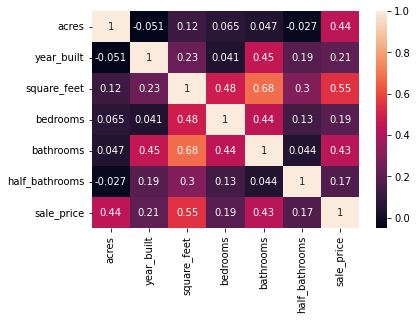

In [171]:
correlation_matrix = df.corr(method='pearson')
sns.heatmap(correlation_matrix, annot=True)

As you can see, the feature with the strongest correlation with sales price is square footage.

c:\Users\Jonbi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


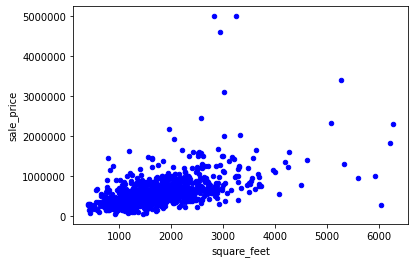

In [172]:
df.plot.scatter(x='square_feet', y='sale_price', c='blue')
plt.ticklabel_format(style='plain', useOffset=False, axis='y')

Here we can see that there is an obvious positive linear relationship between the variables. Let's look at the equation for simple linear regression.

<img src="Capture.PNG" width="400" />


- E(y) is the estimated value of y (sales price)
- $\beta_{0}$ is the y intercept 
- $\beta_{1}$ is the slope
- x is the given value of x (square footage)

In plain english this is saying that the expected home price is equal to the slope multiplied by a given value of x, plus the y intercept. This may look familiar to you if you remember the slope intercept form of a line from high school algebra. If we used *m* to represent the slope and *b* to represent the y intercept and changed the order, we'd have *y = mx + b*! That’s all well and good, but how do we get the slope and y intercept from our data? Let's start with the formula for calculating the slope.

<img src="slope.PNG" width="400" />

If you aren't accustomed to working with formulas, this may look a little unwieldy. Once we know what all of these symbols mean you’ll see that it is much less complicated than it looks.

- $\beta_{0}$  is the y intercept
- $\beta_{1}$ is the slope.
- $y_{i}$ is the value of y
- $x_{i}$  is the value of the independent x
- $\bar{x}$  is the mean of the independent variable
- $\bar{y}$ is the mean of the dependent variable
- ∑ is called sigma and is used to denote a sum of multiple terms. 


Let’s determine out what this is saying in plain english. To calculate the numerator we will need to:

<ol>
    <li> Subtract the value of every x from the mean of x
    <li> Subtract the value of every y from the mean of y
    <li> Multiply the results of the previous two steps
    <li> Add up all of the products (we should have 1,097)
</ol>


To calculate the denominator we will need to 

<ol>
    <li>Subtract the value of every x from the mean of x (just like we did previously)
    <li>Square the resulting product
    <li>Add up all of the products
</ol>

The last step is to divide the results and we have our slope! As you can see, none of the steps above are complicated, but each step has to be repeated for every row in our dataset. Since our goal is to understand why this formula works, it's worth taking a closer look at what this formula is doing. 

In the first two steps for both the numerator and the denominator we’re subtracting the *value* of x or y from the *mean*. These are also called the residual, or error for each x, y pair. Put another way, we’re finding how much each x, y pair deviates from the mean. There is quite a bit of overlap between this slope formula and the formula for calculating standard deviation. Instead rewriting this formula in python and iterating through the records in our datadrame, I’m going to create another dataframe so that we can see walk through this formula one step at a time.



In [173]:
calculations = pd.DataFrame({'x (square_feet)': [], 'y (sale_price)': [], 'square_feet_deviation': [], 'sale_price_deviation': [], 'deviation_products': [], 'square_feet_deviation_squared': []})
calculations = calculations.astype(float)

Next I’ll grab the x and y values from our data frame and bring them over to the calculations dataframe.

In [174]:
calculations['x (square_feet)'] = df['square_feet']
calculations['y (sale_price)'] = df['sale_price']

We know that our formula uses the mean of x and y, so let’s calculate those.

In [175]:
mean_of_x = calculations['x (square_feet)'].mean()
mean_of_y = calculations['y (sale_price)'].mean()
print(mean_of_x)
print(mean_of_y)

1672.3366788321168
556561.8494525547


Now we can begin going through the steps of the slope formula and populating the columns with our results. First we subtract the value of every x from the mean of x to and put the results in the square feet deviations column.

<img src="xi.PNG" width="200" />

In [176]:
calculations['square_feet_deviation'] = calculations['x (square_feet)'].subtract(mean_of_x)

For the third step we multiply the deviations together and add the result to the deviations product column.

<img src="[z_plane.png](https://github.com/jonbig/Data_Science_Portfolio/blob/main/data_analysis_projects/linear_regression_from_scratch/images/xy.PNG)">

In [177]:
calculations['deviation_products'] = calculations['square_feet_deviation'].mul(calculations['sale_price_deviation'])

Now we will square the square feet deviations.

<img src="xden.PNG" width="200" />

In [178]:
calculations['square_feet_deviation_squared'] = calculations['square_feet_deviation'].mul(calculations['square_feet_deviation'])

Let's take a quick look to make sure all of our calculations have populated in the correct coumns of our dataframe.

In [179]:
calculations.head()

,x (square_feet),y (sale_price),square_feet_deviation,sale_price_deviation,deviation_products,square_feet_deviation_squared
0,896.00,"290,000.00",-776.34,NaN,NaN,"602,698.64"
1,"2,428.00","1,600,000.00",755.66,NaN,NaN,"571,027.05"
2,"1,373.00","430,000.00",-299.34,NaN,NaN,"89,602.45"
3,"2,396.00","365,000.00",723.66,NaN,NaN,"523,688.60"
4,768.00,"376,000.00",-904.34,NaN,NaN,"817,824.83"


Now we can add all deviation products together to get the numerator of the slope.

<img src="sum x.PNG" width="300" />

In [180]:
sum_deviation_products = calculations['deviation_products'].sum()
print(sum_deviation_products)


0.0



Then we add the square feet deviations together to get the denominator of our slope.

<img src="xx.PNG" width="200" />

In [181]:
sum_square_feet_deviations_squared = calculations['square_feet_deviation_squared'].sum()
print(sum_square_feet_deviations_squared)

616233730.7655109


The last step to find our slope is to divide the numerator by the denominator and we have our slope!

<img src="div.PNG" width="300" />

In [182]:
slope = sum_deviation_products/sum_square_feet_deviations_squared
print(slope)

0.0


Next we need to calculate the y intercept:

<img src="ycept.PNG" width="300" />

This formula is much less complcated than the slope formula. It tells us that the y intercept is equal to the mean of the dependent variable minus the product of the slope and the mean of the independent variable. We already have our slope and the mean of the dependent variable so we can easily calculate the y intercept.

This formula is much simpler. It tells us that the intercept is equal to the mean of the dependent variable minus the product of the slope and the mean of the independent variable. This time we don’t need to worry about doing 1,000 calculations, and we already have our slope and the mean of the dependent variable so we can easily calculate the y intercept.

In [183]:
y_intercept = mean_of_y - slope * mean_of_x
print(y_intercept)

556561.8494525547


Now we have our model! According to these calculations or model is <strong>E(y) = 61370.1400 + 296.1076(x)</strong>. Before we plot our line, we need to write a quick function that takes a slope and y intercept as parameters and plots the resulting line.

In [184]:
def regression_line(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

Now we can call our regression line function on our scatter plot to see how our model looks.

c:\Users\Jonbi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


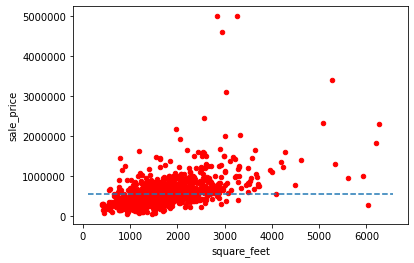

In [185]:
df.plot.scatter(x='square_feet', y='sale_price',c='red')
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
regression_line(slope, y_intercept)
plt.show()

This definitely looks like a best fit line to me, but how do we know for sure? One way is to use seaborn’s regplot function to plot a linear regression and see if it looks the same as the one we built from scratch. 

<AxesSubplot: xlabel='square_feet', ylabel='sale_price'>

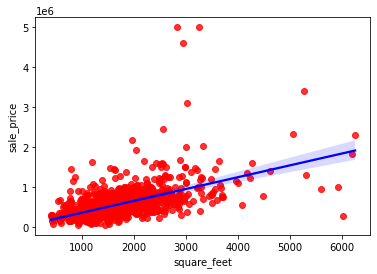

In [186]:
sns.regplot(x="square_feet", y="sale_price", data=df, scatter_kws={"color": "red"}, line_kws={"color": "blue"})

The two models definitely seem to match at least at a glance, but we can get more precise. Using the statsmodels library we can calculate a simple linear regression and examine the coefficients to see if they match the coefficients we calculated.

In [187]:
from statsmodels.formula.api import ols
model_name = ols('sale_price ~ square_feet', data=df).fit()
model_name.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     470.1
Date:                Wed, 04 Jan 2023   Prob (F-statistic):           5.32e-87
Time:                        16:48:14   Log-Likelihood:                -15510.
No. Observations:                1096   AIC:                         3.102e+04
Df Residuals:                    1094   BIC:                         3.103e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    6.137e+04    2.5e+04      2.452      0.014    1.23e+04     1.1e+05
square_feet   296.1077     13.657     21.681      0.000     269.310     322.905
==============================================================================
Omnibus:                     1189.181   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           126037.274
Skew:                           5.082   Prob(JB):                         0.00
Kurtosis:                      54.543   Cond. No.                     4.48e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


Statsmodel calculated y intercept of 6.137e+04. If we convert the scientific e notation to real number, we get 61,370. That’s almost an exact match of our calculated y intercept was 61,370.14. The slight difference is due to rounding. Statsmodel calculated a slope of 296.1077 which exactly matches our calculated slope. We successfully built a simple linear regression model from scratch! 

But how well does the model perform? Statsmodel gives us several metrics we can use to determine how well our model fits the underlying data. The metric I’m focusing on is the coefficient of determination, or $r^2$. Here is the formula for $r^2$. You will notice some similarities between this formula and the formulas we've already worked with. 

<img src="r2.PNG" width="400" />

Our model has an $r^2$ of 0.301. That means the model explains around 30% of the variance of a home’s sales price. That is not a great score, and it’s probably not surprising if you examined the scatter plot and pearson correlation coefficient. Maybe we can build a better model by incorporating more independent variables, but we will have to save that for our multiple regression from scratch project. Hopefully this project helped you gain an intuitive understand of how linear regression works.

https://github.com/jonbig/Data_Science_Portfolio/blob/main/data_analysis_projects/linear_regression_from_scratch/r2.PNG
